In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pykitti
import sys
from tqdm import tqdm
import sympy
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix
from sklearn.metrics import mean_squared_error
from ahrs.filters import AngularRate
sys.path.append('../src')

from filterpy.kalman import ExtendedKalmanFilter
from utils import lla_to_enu, normalize_angles

%matplotlib inline
np.random.seed(777)

In this notebook, Extended Kalman filter is introduced to the Kitti dataset.
Kalman filter is often used to estimate state vector, such as position of vehicle, in linear system. However, Kalman filter can only be applied to the linear system where current state vector has a linear depenency to the previous state vector.
Extended Kalman filter, on the other hand, can estimate state vector in non-linear system, where output after transforming previous state vector is not gaussian, by approximating non-linear function with linear function using first-order Taylor expansion.

Taylor expansion consists of infinite sum of polynomials as follows:

$$\begin{align}
f(x) &\approx f(a) + (x-a)*f'(a)/1! +
    (x-a)^{2} * f''(a)/2! +
    (x-a)^{n} * f^{(n)}(a) / n!\\
    &\approx \sum^{\infty}_{n=0} (x-a)^{n} * f^{(n)}(a) / n!
\end{align}
$$
where, $f^{(n)}(a)$ is $n^{th}$ order derivative function of f(x) evaluated at point a.

In Extended kalman filter, we are interested in the first derivative of the function f(x) evaluated at $\mu$. Hence, our approximated function is:
$$\begin{align}
f(x) &\approx f(\mu) + (x-\mu)*f'(\mu)
\end{align}
$$
where, 
$$\begin{align}
f'(\mu) = \partial f(\mu) / \partial x
\end{align}
$$.

By Taylor expansion, we can approximate our function and obtain linearized function f(x) evaluated at point $\mu$ so that gaussian distribution is obtained after linear transformation of input.

Now, we have linearlized state space model (a.k.a process model) and measurement model (a.k.a observation model) as shown below:
$$\begin{align}
f(x) &\approx f(\mu) + (x-\mu)*f'(\mu)
\end{align}
$$
$$\begin{align}
h(x) &\approx h(\mu) + (x-\mu)*h'(\mu)
\end{align}
$$

Since we have nonlinear model for prediction and measurement step, those model cannot be directly applied to the covariance matrix. Thus, Jacobians are used instead of the function f and h for propagating the covariance matrix.

The Jacobian matrices are obtained as follows:
$$\mathbf 
    F_{j} = 
    \begin{bmatrix}
        \mathtt{\partial f_{1} / \partial x_{1} \partial f_{1} / \partial x_{2} ... \partial f_{1} / \partial x_{n}} \\
        \mathtt{\partial f_{2} / \partial x_{1} \partial f_{2} / \partial x_{2} ... \partial f_{2} / \partial x_{n}} \\
        \mathtt{...} \\
        \mathtt{\partial f_{n} / \partial x_{1} \partial f_{n} / \partial x_{2} ... \partial f_{n} / \partial x_{n}}
    \end{bmatrix}
$$

$$\mathbf 
    H_{j} = 
    \begin{bmatrix}
        \mathtt{\partial h_{1} / \partial x_{1} \partial h_{1} / \partial x_{2} ... \partial h_{1} / \partial x_{n}} \\
        \mathtt{\partial h_{2} / \partial x_{1} \partial h_{2} / \partial x_{2} ... \partial h_{2} / \partial x_{n}} \\
        \mathtt{...} \\
        \mathtt{\partial h_{m} / \partial x_{1} \partial h_{m} / \partial x_{2} ... \partial h_{m} / \partial x_{n}}
    \end{bmatrix}
$$

where, $F_{j}$ and $H_{j}$ are Jacobian metrices for process model and measurement model. The state vector x is of dimension n and measurement vector z is of dimension m.

Finally, the equation of Extended Kalman filter is explained as:
in Prediction step:
$$\begin{align}
\hat x^{-}_{k} &= f(\hat x_{k-1}, u_{k}) \\
P^{-}_{k} &= F_{j, k}*P_{k-1}*F_{j, k}^{T} + Q_{k} \\
\end{align}
$$

in Measurement step:
$$\begin{align}
K_{k} &= P^{-}_{k} * H_{j, k}^{T} * (H_{j, k} * P^{-}_{k} * H_{j, k}^{T} + R_{k}) \\
\hat x_{k} &= \hat x^{-}_{k} + K_{k} * (z_{k} - h(\hat x^{-}_{k}) \\
P_{k} &= (I - K_{k}*H_{j, k})*  P^{-}_{k} \\
\end{align}
$$

## Setup1 (IMU input -> EKF with Visual Odometry measurement)

In the setup1, we utilze IMU sensor values as a control vector input and Visual Odometry result as a measurement in correction step.

The state vector x is defined as:
$$\mathbf 
    x = 
    \begin{bmatrix}
        \mathtt{p_{x}},
        \mathtt{p_{y}},
        \mathtt{p_{z}},
        \mathtt{v_{x}},
        \mathtt{v_{y}},
        \mathtt{v_{z}},
        \mathtt{q_{1}},
        \mathtt{q_{2}},
        \mathtt{q_{3}},
        \mathtt{q_{4}}
    \end{bmatrix}^{T}
$$
where, $p_{i}$ and $v_{i}$ represent position and velocity at/along x, y and z. $q_{i}$ is the orientation in quaternion representation.

The control input vector, which is acquired from the IMU sensor, is:
$$\mathbf 
    {\vec{u_{k}}} = 
    \begin{bmatrix}
        \mathtt{a_{k}} \\
        \mathtt{w_{k}}
    \end{bmatrix}
$$
where, $a_{k}$ and $w_{k}$ represent acceleration and angular velocity along/about x, y and z axis.

According to the kinematics equations, displacement and velocity at time instance t are written as follows:

$$\begin{align}
    p_{t} &= p_{t-1} v_{t-1} * \Delta t + a*\Delta t^{2}/2 \\ 
    v_{t} &= v_{t-1} + \Delta t * a
    \end{align}
$$

Our inertial navigation equations are written as:

$$\begin{align}
    p_{k} &= p_{k-1} v_{k-1} * \Delta t + \frac{\Delta t^{2}}{2} * (R(q_{k-1}* a_{k} - g) \\ 
    v_{k} &= v_{k-1} + \Delta t * (R(q_{k-1}* a_{k} - g) \\
    q_{k} &= (
            cos(\frac{\|w_{k}\| * \Delta t}{2})* I_{4}
            + \frac{1}{\|w_{k}\|} * sin(\frac{\|w_{k}\| * \Delta t}{2}) * \Omega_{k}
        ) * q_{k-1}
    \end{align}
$$
where, quaternion update matrix is defined as:
$$\mathbf 
    \Omega_{k} = 
    \begin{bmatrix}
        0 & [w_{k}]_{z} & [w_{k}]_{y} & [w_{k}]_{x} \\
        -[w_{k}]_{z} & 0 & [w_{k}]_{x} & [w_{k}]_{y} \\
        [w_{k}]_{y} & -[w_{k}]_{x} & 0 & [w_{k}]_{z} \\
        -[w_{k}]_{x} & -[w_{k}]_{y} & -[w_{k}]_{z} & 0 \\
    \end{bmatrix}
$$.

$$\mathbf 
    R(q_{k}) = 
    \begin{bmatrix}
        q^{2}_{1} + q^{2}_{2} + q^{2}_{3} + q^{2}_{4} 
            & 2(q_{2}q_{3} - q_{1}q_{4}) 
            & 2(q_{1}q_{3} + q_{2}q_{4}) \\
        2(q_{2}q_{3} + q_{1}q_{4}) 
            & q^{2}_{1} - q^{2}_{2} + q^{2}_{3} -q^{2}_{4} 
            & 2(q_{3}q_{4} - q_{1}q_{2})  \\
         2(q_{2}q_{4} - q_{1}q_{3}) 
             & 2(q_{1}q_{2} + q_{3}q_{4}) 
             & q^{2}_{1} - q^{2}_{2} - q^{2}_{3} + q^{2}_{4}  \\
    \end{bmatrix} = 
    \begin{bmatrix}
        R_{1,1} & R_{1,2} & R_{1,3} \\
        R_{2,1} & R_{2,2} & R_{2,3} \\
        R_{3,1} & R_{3,2} & R_{3,3}
    \end{bmatrix}
$$.
R is a rotation matrix that transform a vector from the body coordinate to the navigation coordinate frame.

$$\mathbf 
    g = 
    \begin{bmatrix}
        0 & 0 & 9.81
    \end{bmatrix}^{T}
$$
where g is a gravitational acceleration vector applied to z axis.

In the update step, each of the variable in the state vector is updated by the following equations.
For the positions:
$$\begin{align}
    P_{x, k}^{-} &= P_{x, k-1} + v_{x, k-1} * \Delta t + 0.5 * (R_{1,1}*a_{x} + R_{1,2}*a_{y} + R_{1,3} * a_{z} - 9.81) * \Delta t^{2} \\ 
    P_{y, k}^{-} &= P_{y, k-1} + v_{y, k-1} * \Delta t + 0.5 * (R_{2,1}*a_{x} + R_{2,2}*a_{y} + R_{2,3} * a_{z} - 9.81) * \Delta t^{2} \\ 
    P_{z, k}^{-} &= P_{z, k-1} + v_{z, k-1} * \Delta t + 0.5 * (R_{3,1}*a_{x} + R_{3,2}*a_{y} + R_{3,3} * a_{z} - 9.81) * \Delta t^{2} \\ 
    \end{align}
$$

For the velocities:
$$\begin{align}
    v_{x, k}^{-} &= v_{x, k-1} + (R_{1,1}*a_{x} + R_{1,2}*a_{y} + R_{1,3} * a_{z} - 9.81) * \Delta t \\ 
    v_{y, k}^{-} &= v_{y, k-1} + (R_{2,1}*a_{x} + R_{2,2}*a_{y} + R_{2,3} * a_{z} - 9.81) * \Delta t \\ 
    v_{z, k}^{-} &= v_{z, k-1} + (R_{3,1}*a_{x} + R_{3,2}*a_{y} + R_{3,3} * a_{z} - 9.81) * \Delta t \\ 
    \end{align}
$$

For the quaternion:
since the general equation for quaternion is expressed as:
$$
\begin{align}
    q_{k} = (cos(\frac{\|w_{k}\| * \Delta t}{2})* I_{4}
            + \frac{1}{\|w_{k}\|} * sin(\frac{\|w_{k}\| * \Delta t}{2}) * \Omega_{k}) * q_{k-1}
\end{align}
$$.

In the equation, the norm of angular velocities about each axis, x, y, z is obtained as $\|w_{k}\| = \sqrt{w_{x, k}^{2} + w_{y, k}^{2} + w_{z, k}^{2}}$.

To understand the equation, the simplified matrix is shown below.
$$
\begin{align}
    cos(0.5 * \|w_{k}\| * \Delta t)* I_{4} &= 
    \begin{bmatrix}
        cos(0.5 * \|w_{k}\|*\Delta t) & 0 & 0 & 0 \\
        0 & cos(0.5 * \|w_{k}\|*\Delta t) & 0 & 0 \\
        0 & 0 & cos(0.5 * \|w_{k}\|*\Delta t) & 0 \\
        0 & 0 & 0 & cos(0.5 * \|w_{k}\|*\Delta t)
    \end{bmatrix} = A\in R^{4,4} \\
    \frac{1}{\|w_{k}\|} * sin(0.5 * \|w_{k}\| * \Delta t)*\Omega_{k} &=
    \begin{bmatrix}
        0 & 
        \frac{w_{z,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) & 
        \frac{w_{y,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) & 
        \frac{w_{x,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) \\
        -\frac{w_{x,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) &
        0 &
        \frac{w_{y,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) &
        \frac{w_{z,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) \\
        \frac{w_{y,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) &
        - \frac{w_{x,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) & 
        0 &
        \frac{w_{z,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) \\
        - \frac{w_{x,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) &
        - \frac{w_{y,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) & 
        - \frac{w_{z,k}}{\|w_{k}\|}*sin(0.5*\|w_{k}\|*\Delta t) &
        0
    \end{bmatrix} = B\in R^{4,4} \\
    q_{k} &= (A + B)*q_{k-1} \\
          &= 
            \begin{bmatrix}
                A_{1,1} & B_{1,2} & B_{1,3} & B_{1,4} \\
                B_{2,1} & A_{2,2} & B_{2,3} & B_{2,4} \\
                B_{3,1} & B_{3,2} & A_{3,3} & B_{3,4} \\
                B_{4,1} & B_{4,2} & B_{4,3} & A_{4,4} \\
            \end{bmatrix} * 
            \begin{bmatrix}
                q_{0,k-1} \\ q_{1,k-1} \\ q_{2,k-1} \\ q_{3,k-1}
            \end{bmatrix} \\
         &=
            \begin{bmatrix}
                A_{1,1}*q_{1,k-1} + B_{1,2}*q_{2,k-1} + B_{1,3}*q_{3,k-1} + B_{1,4}*q_{4,k-1} \\
                B_{2,1}*q_{2,k-1} + A_{2,2}*q_{2,k-1} + B_{2,3}*q_{3,k-1} + B_{2,4}*q_{4,k-1} \\
                B_{3,1}*q_{3,k-1} + B_{3,2}*q_{2,k-1} + A_{3,3}*q_{3,k-1} + B_{3,4}*q_{4,k-1} \\
                B_{4,1}*q_{4,k-1} + B_{4,2}*q_{2,k-1} + B_{4,3}*q_{3,k-1} + A_{4,4}*q_{4,k-1} \\
            \end{bmatrix}
\end{align}
$$

Hence, update function is written as:

$$\begin{align}
     {\hat{x_{k}^{-}}} &= 
            \begin{bmatrix}
                f_{1} \\
                f_{2} \\
                f_{3} \\
                . \\
                . \\
                f_{10} \\
            \end{bmatrix} \\
            &=
            \begin{bmatrix}
                P_{x, k-1} + v_{x, k-1} * \Delta t + 0.5 * (R_{1,1}*a_{x} + R_{1,2}*a_{y} + R_{1,3} * a_{z} - 9.81) * \Delta t^{2} \\ 
                P_{y, k-1} + v_{y, k-1} * \Delta t + 0.5 * (R_{2,1}*a_{x} + R_{2,2}*a_{y} + R_{2,3} * a_{z} - 9.81) * \Delta t^{2} \\ 
                P_{z, k-1} + v_{z, k-1} * \Delta t + 0.5 * (R_{3,1}*a_{x} + R_{3,2}*a_{y} + R_{3,3} * a_{z} - 9.81) * \Delta t^{2} \\ 
                v_{x, k-1} + (R_{1,1}*a_{x} + R_{1,2}*a_{y} + R_{1,3} * a_{z}) * \Delta t \\ 
                v_{y, k-1} + (R_{2,1}*a_{x} + R_{2,2}*a_{y} + R_{2,3} * a_{z}) * \Delta t \\ 
                v_{z, k-1} + (R_{3,1}*a_{x} + R_{3,2}*a_{y} + R_{3,3} * a_{z} - 9.81) * \Delta t \\ 
                A_{1,1}*q_{1,k-1} + B_{1,2}*q_{2,k-1} + B_{1,3}*q_{3,k-1} + B_{1,4}*q_{4,k-1} \\
                B_{2,1}*q_{1,k-1} + A_{2,2}*q_{2,k-1} + B_{2,3}*q_{3,k-1} + B_{2,4}*q_{4,k-1} \\
                B_{3,1}*q_{1,k-1} + B_{3,2}*q_{2,k-1} + A_{3,3}*q_{3,k-1} + B_{3,4}*q_{4,k-1} \\
                B_{4,1}*q_{1,k-1} + B_{4,2}*q_{2,k-1} + B_{4,3}*q_{3,k-1} + A_{4,4}*q_{4,k-1} \\
            \end{bmatrix}
    \end{align}
$$

The state transition matrix, the Jacobian matrix of the function $f(x_{k}, \vec u_{k})$ with respect to the state vector x($p_{x}, p_{y}, p_{z}, v_{x}, v_{y}, v_{z}, q_{1}, q_{2}, q_{3}, q_{4}$) is obtained by:

$$\begin{align}
     F_{j, k} = 
            \begin{bmatrix}
                \frac{\partial f_{1}}{\partial P_{x}} & \frac{\partial f_{1}}{\partial P_{y}} &
                \frac{\partial f_{1}}{\partial P_{z}} & ... \frac{\partial f_{1}}{\partial q_{4}}\\
                \frac{\partial f_{2}}{\partial P_{x}} & \frac{\partial f_{2}}{\partial P_{y}} &
                \frac{\partial f_{2}}{\partial P_{z}} & ... \frac{\partial f_{2}}{\partial q_{4}}\\
                \frac{\partial f_{3}}{\partial P_{x}} & \frac{\partial f_{3}}{\partial P_{y}} &
                \frac{\partial f_{3}}{\partial P_{z}} & ... \frac{\partial f_{3}}{\partial q_{4}}\\
                . \\
                . \\
                \frac{\partial f_{10}}{\partial P_{x}} & \frac{\partial f_{10}}{\partial P_{y}} &
                \frac{\partial f_{10}}{\partial P_{z}} & ... \frac{\partial f_{10}}{\partial q_{4}}\\
            \end{bmatrix}
    \end{align}
$$

The noise gain matrix, the Jacobian matrix of the function $f(x_{k}, \vec u_{k})$ with respect to the input control vector $\vec u(a_{x}, a_{y}, a_{z}, w_{x}, w_{y}, w_{z})$, is obtained by:

$$\begin{align}
     G_{j, k} = 
            \begin{bmatrix}
                \frac{\partial f_{1}}{\partial a_{x}} & \frac{\partial f_{1}}{\partial a_{y}} &
                \frac{\partial f_{1}}{\partial a_{z}} & ... \frac{\partial f_{1}}{\partial w_{z}}\\
                \frac{\partial f_{2}}{\partial a_{x}} & \frac{\partial f_{2}}{\partial a_{y}} &
                \frac{\partial f_{2}}{\partial a_{z}} & ... \frac{\partial f_{2}}{\partial w_{z}}\\
                \frac{\partial f_{3}}{\partial a_{x}} & \frac{\partial f_{3}}{\partial a_{y}} &
                \frac{\partial f_{3}}{\partial a_{z}} & ... \frac{\partial f_{3}}{\partial w_{z}}\\
                . \\
                . \\
                \frac{\partial f_{10}}{\partial a_{x}} & \frac{\partial f_{10}}{\partial a_{y}} &
                \frac{\partial f_{10}}{\partial a_{z}} & ... \frac{\partial f_{10}}{\partial w_{z}}\\
            \end{bmatrix}
    \end{align}
$$


## Load raw data 0020

In [36]:
kitti_root_dir = '../data'
kitti_date = '2011_09_30'
kitti_drive = '0033'

dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

Extract vehicle GPS trajectory, yaw angle, yaw rate, and forward velocity from KITTI OXTS senser packets.

These are treated as ground-truth trajectory in this experiment.

In [37]:
GPS_measurements = []  # [longitude(deg), latitude(deg), altitude(meter)] x N from GPS
VO_measurements = [] # [longitude(deg), latitude(deg)] x N from Visual Odometry
IMU_outputs = [] # [acc_x, acc_y, acc_z, ang_vel_x, ang_vel_y, ang_vel_z] x N from IMU
INS_angles = [] # [roll(rad), pitch(rad), yaw(rad)] x N
INS_velocities = [] # [forward velocity, leftward velocity, upward velocity] x N from INS

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    GPS_measurements.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    # when VO is available
    # VO_measurements.append([])
    IMU_outputs.append([
        packet.ax,
        packet.ay,
        packet.az,
        packet.wx,
        packet.wy,
        packet.wz
    ])
    INS_angles.append([
        packet.roll,
        packet.pitch,
        packet.yaw
    ])
    INS_velocities.append([
        packet.vf,
        packet.vl,
        packet.vu
    ])

GPS_measurements = np.array(GPS_measurements).T
VO_measurements = np.array(VO_measurements).T
IMU_outputs = np.array(IMU_outputs)
INS_angles = np.array(INS_angles)
INS_velocities = np.array(INS_velocities)

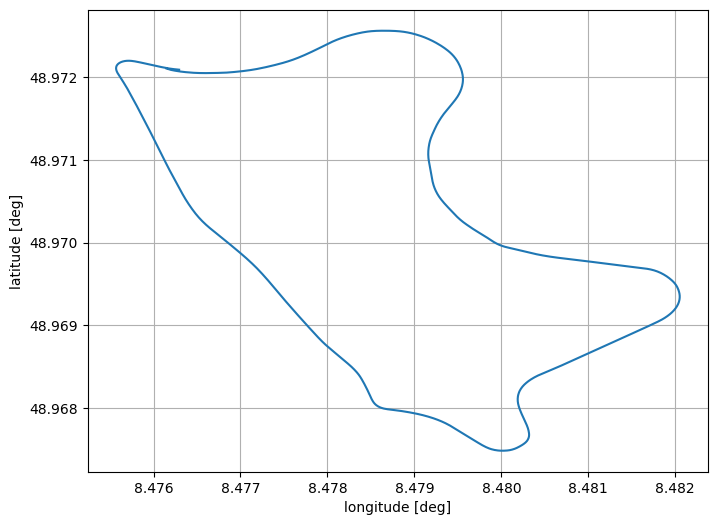

In [38]:
lons, lats, _ = GPS_measurements

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(lons, lats)
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')
ax.grid()

Transform GPS trajectory and visual odometry trajectory from [lon, lat, alt] to local [x, y, z] coord so that Kalman filter can handle it.

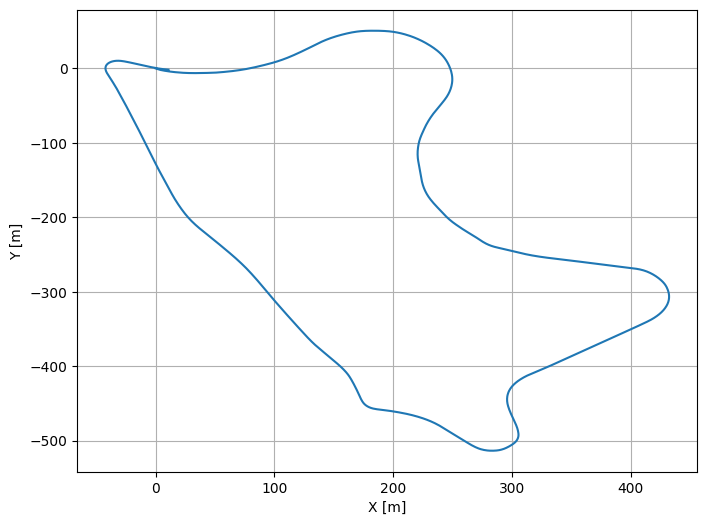

In [39]:
origin = GPS_measurements[:, 0]  # set the initial position to the origin
GPS_measurements_in_meter = lla_to_enu(GPS_measurements, origin)

xs, ys, _ = GPS_measurements_in_meter
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(xs, ys)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid();

Extract timestamps from KITTI data and convert them to seconds elapsed from the first one.

In [40]:
timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed] # dt

## Adding gaussian noise to KITTI INS/IMU data

Now we have following measurement values:
 - x and y values obtained from GPS sensor
 - linear acceleration along x, y, and z axis from IMU sensor
 - angular velocity about x, y, and z axis acquired from IMU sensor
 - forward, leftword, upword velociteies along x, y, z from INS sensor
 - angle about x, y, z from INS sensor

To design measurement step, we add white gaussian noise to the sensor reading denoted as measurement noise matrix R in the filter.

In [41]:
N = len(ts)  # number of data point

### Add noise to GPS data

In [42]:
GPS_measurement_noise_std = 5.0  # standard deviation of observation noise of x and y in meter. so 95% of x and y values fall inside +- 2m from the ground truth.

_gps_noise = np.random.normal(0.0, GPS_measurement_noise_std, (2, N))  # gen gaussian noise
GPS_mesurement_in_meter_with_noise = GPS_measurements_in_meter.copy()
GPS_mesurement_in_meter_with_noise[:2, :] += _gps_noise  # add the noise to ground-truth x and y positions

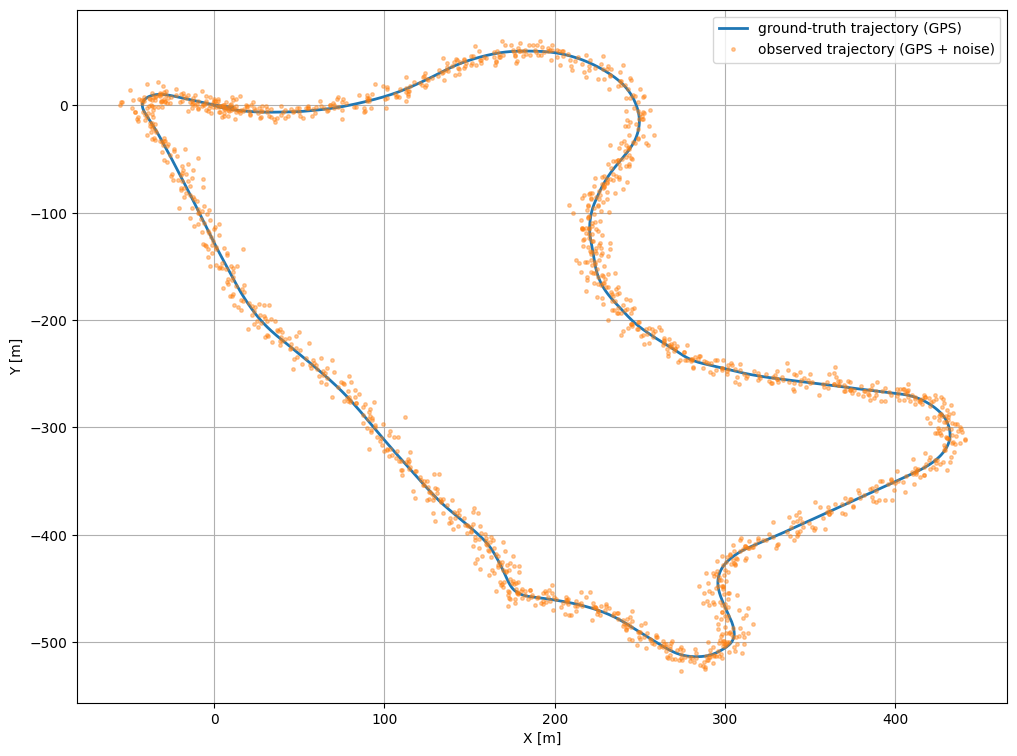

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = GPS_measurements_in_meter
ax.plot(xs, ys, lw=2, label='ground-truth trajectory (GPS)')

xs, ys, _ = GPS_mesurement_in_meter_with_noise
ax.plot(xs, ys, lw=0, marker='.', markersize=5, alpha=0.4, label='observed trajectory (GPS + noise)')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

### Adding noise to IMU sensor data

#### Acceleration

In [44]:
IMU_acc_noise_std = 0.02

IMU_acc_noise = np.random.normal(0.0, IMU_acc_noise_std,(N, 3))  # gaussian noise
IMU_acc_with_noise = IMU_outputs[:, :3].copy()
IMU_acc_with_noise += IMU_acc_noise

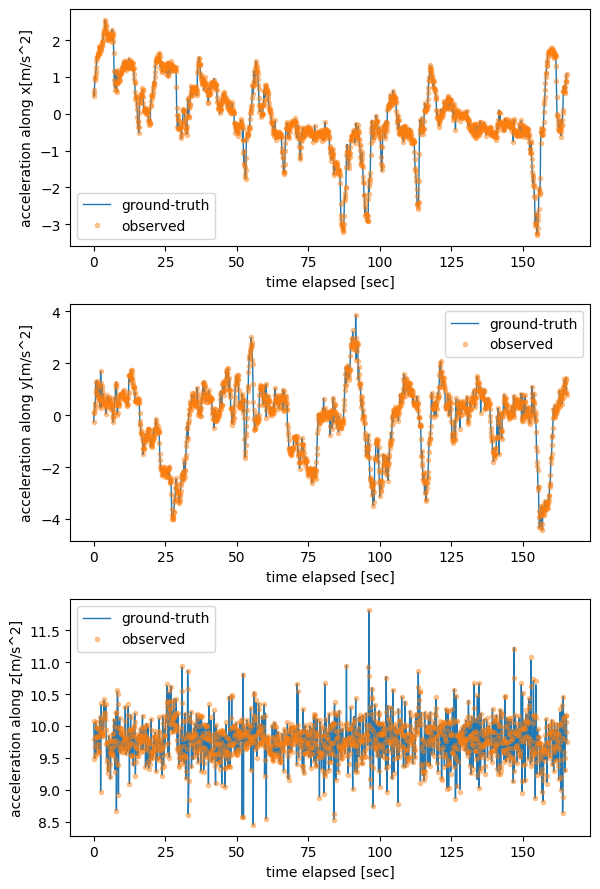

In [45]:
fig, ax = plt.subplots(3, 1, figsize=(6, 9))
acc_y_labels = ['acceleration along x[m/s^2]', 'acceleration along y[m/s^2]', 'acceleration along z[m/s^2]']

for idx in range(1, 4):  
    i = idx - 1
    ax[i].plot(ts, IMU_outputs[:, idx-1:idx], lw=1, label='ground-truth')
    ax[i].plot(ts, IMU_acc_with_noise[:, idx-1:idx], lw=0, marker='.', alpha=0.4, label='observed')
    ax[i].set_xlabel('time elapsed [sec]')
    ax[i].set_ylabel(acc_y_labels[i])
    ax[i].legend()
fig.tight_layout()

#### Angular velocity

In [46]:
IMU_angular_velocity_noise_std = 0.01 # standard deviation of yaw rate in rad/s

IMU_angular_velocity_noise = np.random.normal(0.0, IMU_angular_velocity_noise_std, (N,3))  # gen gaussian noise
IMU_angular_velocity_with_noise = IMU_outputs[:, 3:].copy()
IMU_angular_velocity_with_noise += IMU_angular_velocity_noise  # add the noise to angular velocity as measurement noise

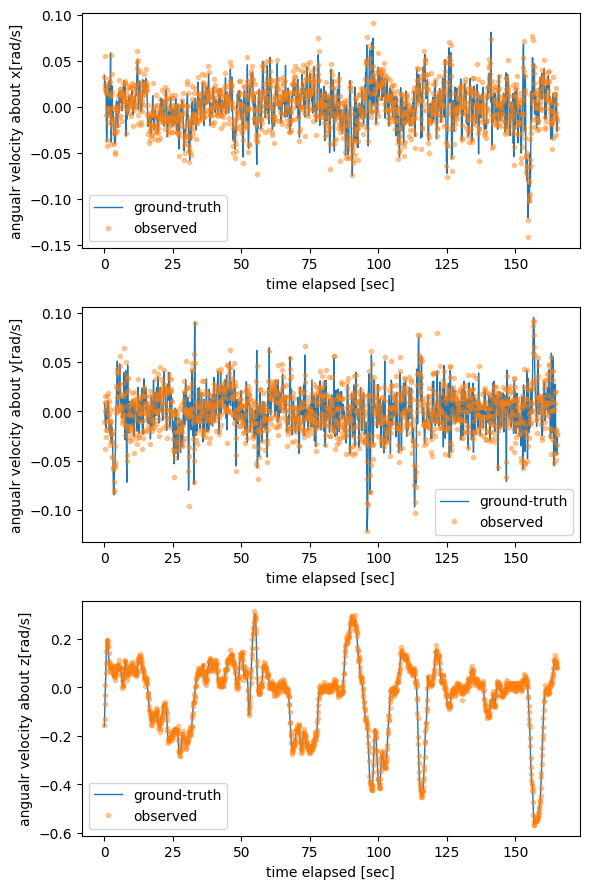

In [47]:
fig, ax = plt.subplots(3, 1, figsize=(6, 9))
angualr_vel_y_labels = ['angualr velocity about x[rad/s]', 'angualr velocity about y[rad/s]', 'angualr velocity about z[rad/s]']

for idx in range(3):  
    i = idx + 4
    ax[idx].plot(ts, IMU_outputs[:, i-1:i], lw=1, label='ground-truth')
    ax[idx].plot(ts, IMU_angular_velocity_with_noise[:, idx:idx+1], lw=0, marker='.', alpha=0.4, label='observed')
    ax[idx].set_xlabel('time elapsed [sec]')
    ax[idx].set_ylabel(angualr_vel_y_labels[idx])
    ax[idx].legend()
fig.tight_layout()

In [48]:
angular_rate = AngularRate(gyr=IMU_angular_velocity_with_noise)

In [49]:
IMU_quaterion = angular_rate.Q

### Adding noise to linear velocity data

In [50]:
INS_velocities.shape

(1594, 3)

In [51]:
velocity_noise_std = 0.3
velocity_noise = np.random.normal(0.0, velocity_noise_std, (N, 3))
INS_velocities_with_noise = INS_velocities.copy()
INS_velocities_with_noise += velocity_noise

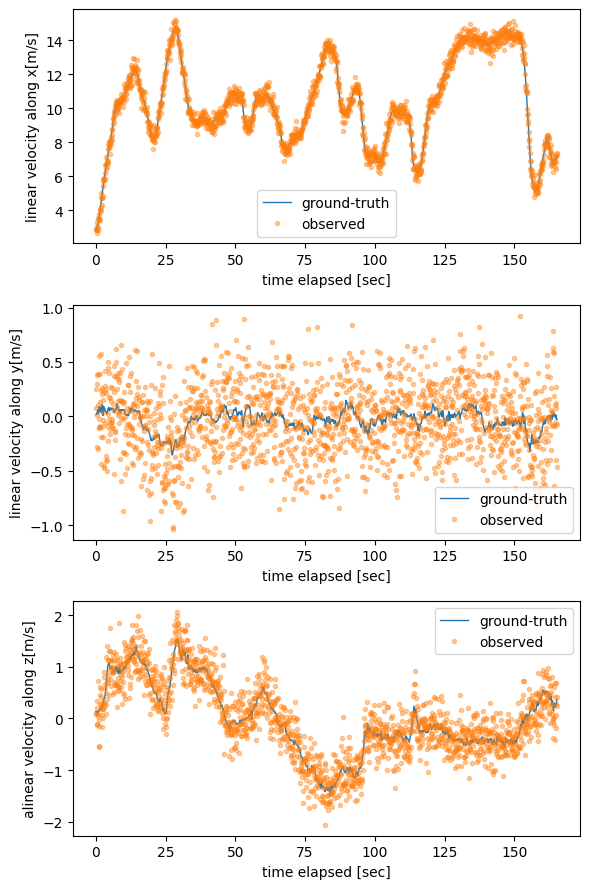

In [52]:
fig, ax = plt.subplots(3, 1, figsize=(6, 9))
linear_velocity_y_labels = ['linear velocity along x[m/s]', 'linear velocity along y[m/s]', 'alinear velocity along z[m/s]']

for idx in range(1, 4):  
    i = idx - 1
    ax[i].plot(ts, INS_velocities[:, idx-1:idx], lw=1, label='ground-truth')
    ax[i].plot(ts, INS_velocities_with_noise[:, idx-1:idx], lw=0, marker='.', alpha=0.4, label='observed')
    ax[i].set_xlabel('time elapsed [sec]')
    ax[i].set_ylabel(linear_velocity_y_labels[i])
    ax[i].legend()
fig.tight_layout()

## Applying Extended Kalman Filter

To design the Extended Kalman filter, covariance matrix P, process noise Q, measurement noise R are prepared.

The initial covariance matrix for state variable (10x10):
$$\mathbf 
    P =
    \begin{bmatrix}
           0.1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
           0 & 0.1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
           0 & 0 & 0.1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
           0 & 0 & 0 & 0.1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
           0 & 0 & 0 & 0 & 0.1 & 0 & 0 & 0 & 0 & 0 \\ 
           0 & 0 & 0 & 0 & 0 & 0.1 & 0 & 0 & 0 & 0 \\ 
           0 & 0 & 0 & 0 & 0 & 0 & 0.1 & 0 & 0 & 0 \\ 
           0 & 0 & 0 & 0 & 0 & 0 & 0 & 0.1 & 0 & 0 \\ 
           0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0.1 & 0 \\ 
           0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0.1 \\ 
    \end{bmatrix}
$$

Process noise covariance matrix (6x6): (zero mean gaussian distribution, which is lies mainy in the control inputs, IMU sensor readings, at the prediction step.)
$$\mathbf 
    Q =
    \begin{bmatrix}
           V(a_{x}) & 0 & 0 & 0 & 0 & 0 \\
           0 & V(a_{y}) & 0 & 0 & 0 & 0 \\ 
           0 & 0 & V(a_{z}) & 0 & 0 & 0 \\ 
           0 & 0 & 0 & V(w_{x}) & 0 & 0 \\ 
           0 & 0 & 0 & 0 & V(w_{y}) & 0 \\ 
           0 & 0 & 0 & 0 & 0 & V(w_{z}) \\
    \end{bmatrix}
$$

Measurement noise (x and y coordinate):
$$\mathbf 
    R =
    \begin{bmatrix}
        V(P_{x}) & 0 \\
        0 & V(P_{y})
    \end{bmatrix}
$$

In [53]:
class ExtendedKalmanFilter_setup1:
    """Extended Kalman Filter
    for vehicle whose motion is modeled as eq. (5.9) in [1]
    and with observation of its 2d location (x, y)
    """
    x = None
    P = None
    R = None
    px = symbols('p_{x}')
    py = symbols('p_{y}')
    pz = symbols('p_{z}')
    
    vx = symbols('v_{x}')
    vy = symbols('v_{y}')
    vz = symbols('v_{z}')
    
    q1 = symbols('q1')
    q2 = symbols('q2')
    q3 = symbols('q3')
    q4 = symbols('q4')
    
    ax = symbols('a_{x}')
    ay = symbols('a_{y}')
    az = symbols('a_{z}')
    wx = symbols('w_{x}')
    wy = symbols('w_{y}')
    wz = symbols('w_{z}')

    dt = symbols('dt')
    norm_w = symbols('\|w\|')
    aR1 = symbols('aR_{1}')
    aR2 = symbols('aR_{2}')
    aR3 = symbols('aR_{3}')
    qk = Matrix([
        [1],[0],[0],[0]
    ])
    g = Matrix([
        [0],[0],[9.81]
    ])

    errors = []
    
    def __init__(self, x, P, H):
        """ 
        Args:
            x (numpy.array): state to estimate: [x_, y_, theta]^T
            P (numpy.array): estimation error covariance
        """
        
        R = Matrix([[self.q1**2 + self.q2**2 - self.q3**2 + self.q4**2, 
                     2*(self.q2*self.q3 - self.q1*self.q4), 
                     2*(self.q1*self.q3 + self.q2*self.q4)],
                    [2*(self.q2*self.q3 + self.q1*self.q4), 
                     self.q1**2 - self.q2**2 + self.q3**2 - self.q4**2, 
                     2*(self.q3*self.q4 - self.q1*self.q2)],
                    [2*(self.q2*self.q4 - self.q1*self.q3), 2*(self.q1*self.q2 + self.q3*self.q4), 
                     self.q1**2 - self.q2**2 - self.q3**2 + self.q4**2]
           ])
        Omega = Matrix([
            [0, self.wz, -self.wy, self.wx],
            [-self.wz, 0, self.wx, self.wy],
            [self.wy, -self.wx, 0, self.wz],
            [-self.wx, -self.wy, -self.wz, 0]
        ])
        # Omega = Matrix([
        #     [0, -self.wx, -self.wy, -self.wz],
        #     [self.wz, 0, self.wx, -self.wy],
        #     [self.wy, -self.wz, 0, self.wx],
        #     [self.wz, self.wy, -self.wx, 0]
        # ])
        A = sympy.cos(self.norm_w*self.dt/2) * sympy.eye(4)
        B = (1/self.norm_w)*sympy.sin(self.norm_w*self.dt/2) * Omega
        # A = sympy.eye(4)
        # B = self.dt / 2 * Omega
        # self.fxu = Matrix([
        #     [self.px + self.vx*self.dt + 1/2 * (R[0,0]*self.ax-self.g[0] + R[0,1]*self.ay-self.g[1] + R[0,2]*self.az-self.g[2])*self.dt**2],
        #     [self.py + self.vy*self.dt + 1/2 * (R[1,0]*self.ax-self.g[0] + R[1,1]*self.ay-self.g[1] + R[1,2]*self.az-self.g[2])*self.dt**2],
        #     [self.pz + self.vz*self.dt + 1/2 * (R[2,0]*self.ax-self.g[0] + R[2,1]*self.ay-self.g[1] + R[2,2]*self.az-self.g[2])*self.dt**2],
        #     [self.vx + (R[0,0]*self.ax-self.g[0] + R[0,1]*self.ay-self.g[1] + R[0,2]*self.az-self.g[2])*self.dt],
        #     [self.vy + (R[1,0]*self.ax-self.g[0] + R[1,1]*self.ay-self.g[1] + R[1,2]*self.az-self.g[2])*self.dt],
        #     [self.vz + (R[2,0]*self.ax-self.g[0] + R[2,1]*self.ay-self.g[1] + R[2,2]*self.az-self.g[2])*self.dt],
        #     [(A + B) * self.qk],
        # ])
        self.fxu = Matrix([
            [Matrix([[self.px],[self.py],[self.pz]]) +  Matrix([[self.vx],[self.vy],[self.vz]]) * self.dt + (R * Matrix([[self.ax],[self.ay], [self.az]]) - self.g)*self.dt**2 / 2],
            [Matrix([[self.vx],[self.vy],[self.vz]]) + (R * Matrix([[self.ax],[self.ay],[self.az]]) - self.g) * self.dt],
            [(A + B) * Matrix([[self.q1],[self.q2],[self.q3],[self.q4]])],
        ])
        state_x = Matrix([self.px, self.py, self.pz, self.vx, self.vy, self.vz, self.q1, self.q2, self.q3, self.q4])
        control_input = Matrix([self.ax, self.ay, self.az, self.wx, self.wy, self.wz])

        self.F = self.fxu.jacobian(state_x)
        self.G = self.fxu.jacobian(control_input)
        self.P = P
        self.H = H
        self.x = x

    def compute_norm_w(self, wx_, wy_, wz_):
        return np.sqrt(wx_**2 + wy_**2 + wz_**2)
        
    def predict(self, u, dt, Q):
        """estimate x and P based on previous stete of x and control input u
        Args:
            u  (numpy.array): control input u
            dt (numpy.array): difference of current time and previous time
            Q  (numpy.array): process noise 
        """
        # propagate state x
        px_, py_, pz_ = self.x[:3, 0]
        vx_, vy_, vz_ = self.x[3:6, 0]
        q1_, q2_, q3_, q4_ = self.x[6:, 0]
        ax_, ay_, az_, wx_, wy_, wz_ = u
        norm_w_ = self.compute_norm_w(wx_, wy_, wz_);
        fxu_values = {
            self.dt: dt,
            self.px: px_,
            self.py: py_,
            self.pz: pz_,
            self.vx: vx_,
            self.vy: vy_,
            self.vz: vz_,
            self.q1: q1_, 
            self.q2: q2_, 
            self.q3: q3_, 
            self.q4: q4_,
            self.ax: ax_,
            self.ay: ay_,
            self.az: az_,
            self.wx: wx_,
            self.wy: wy_, 
            self.wz: wz_,
            self.norm_w: norm_w_
        }
        # predict state vector x
        self.x = np.array(self.fxu.evalf(subs=fxu_values)).astype(float)

        # predict state covariance matrix P
        P_hat = self.F @ self.P @ self.F.T + self.G @ Matrix(Q) @ self.G.T
        self.P = np.array(P_hat.evalf(subs=fxu_values)).astype(float)
        
    def update(self, z, R):
        """update x and P based on observation of (x_, y_)
        Args:
            z (numpy.array): measurement for [x_, y_]^T
            R (numpy.array): measurement noise covariance
        """
        # compute Kalman gain
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + R)
        # update state x
        z_ = np.dot(self.H, self.x)  # expected observation from the estimated state
        self.x = self.x + K @ (z - z_)
        
        self.errors.append(np.sqrt(np.sum((z-z_)**2)))

        # update covariance P
        self.P = self.P - K @ self.H @ self.P

    def plot_error(self):
        plt.plot([i for i in range(len(self.errors))], self.errors, label='Error', color='r')

In [54]:
# initial values
px_, py_, pz_ = GPS_measurements_in_meter[:, 0]
q1_, q2_, q3_, q4_ = IMU_quaterion[0]
ax_, ay_, az_ = IMU_acc_with_noise[0]
wx_, wy_, wz_ = IMU_angular_velocity_with_noise[0]

x_initial = np.array([
    [px_], #Px
    [py_], #Py
    [pz_], #Pz
    [0], #Vx
    [0], #Vy
    [0], #Vz
    [q1_], #q1
    [q2_], #q2
    [q3_], #q3
    [q4_]  #q4
])
P_initial = np.eye(x_initial.shape[0]) * 0.001
# transition matrix from predicted state vector to measurement space
H_initial = np.array([
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
])
# process noise
q_noise = [IMU_acc_noise_std, IMU_acc_noise_std, IMU_acc_noise_std, IMU_angular_velocity_noise_std, IMU_angular_velocity_noise_std, IMU_angular_velocity_noise_std]
i = np.eye(6)
Q_ = Matrix([[val * num for num in i[ind]] for ind, val in enumerate(q_noise)])
# measurement noise
R_ = np.array([
    [GPS_measurement_noise_std ** 2., 0.],
    [0., GPS_measurement_noise_std ** 2.],
])


ekf_setup1_1 = ExtendedKalmanFilter_setup1(x=x_initial, P=P_initial, H=H_initial)

In [55]:
mu_x_setup1_1 = [ekf_setup1_1.x[0, 0],]
mu_y_setup1_1 = [ekf_setup1_1.x[1, 0],]
t_last = 0.

for t_idx in tqdm(range(1, N)):
    t = ts[t_idx]
    dt_ = t - t_last
    ax_, ay_, az_ = IMU_acc_with_noise[t_idx]
    wx_, wy_, wz_ = IMU_angular_velocity_with_noise[t_idx]
    u_ = np.array([
        ax_,
        ay_,
        az_,
        wx_,
        wy_,
        wz_
    ])
    ekf_setup1_1.predict(u=u_, dt=dt_, Q=Q_)
    x_hat = ekf_setup1_1.x.copy()
    mu_x_setup1_1.append(x_hat[0, 0])
    mu_y_setup1_1.append(x_hat[1, 0])
    z_ = GPS_mesurement_in_meter_with_noise[:2, t_idx]
    ekf_setup1_1.update(z=z_.reshape(-1, 1), R=R_)
    t_last = t

  0%|▏                                         | 5/1593 [00:03<20:26,  1.29it/s]


KeyboardInterrupt: 

In [ ]:
ekf_setup1_1.plot_error()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = GPS_measurements_in_meter
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = GPS_mesurement_in_meter_with_noise
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory', color='y')

ax.plot(mu_x_setup1_1, mu_y_setup1_1, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

In [ ]:
error_ekf = mean_squared_error(GPS_measurements_in_meter[:2, :len(mu_x_setup1_1)], np.array([mu_x_setup1_1, mu_y_setup1_1]))
print(f"MSE: {error_ekf}")

In [56]:
# Since symbolic python is too slow, pure numpy implementation is defined.
class ExtendedKalmanFilter1:
    """Extended Kalman Filter
    for vehicle whose motion is modeled as eq. (5.9) in [1]
    and with observation of its 2d location (x, y)
    """
    x = None
    P = None
    R = None
    errors = []
    
    def __init__(self, x, P, H):
        """ 
        Args:
            x (numpy.array): state to estimate: [px, py, pz, vx, vy, vz, q1, q2, q3, q4]
            P (numpy.array): estimation error covariance 10x10
            H (numpy.array): transition matrix from predicted state vector to measurement space 2x10
        """
        self.P = P
        self.H = H
        self.x = x

    def compute_norm_w(self, w):
        return np.sqrt(np.sum(w**2))

    def get_rotation_matrix(self, q):
        q1, q2, q3, q4 = q[:, 0]
        return np.array([
            [q1**2 + q2**2 - q3**2 - q4**2, 2*(q2*q3 - q1*q4), 2*(q1*q3 + q2*q4)],
            [2*(q2*q3 + q1*q4), q1**2 - q2**2 + q3**2 - q4**2, 2*(q3*q4 - q1*q2)],
            [2*(q2*q4 - q1*q3), 2*(q1*q2 + q3*q4), q1**2 - q2**2 - q3**2 + q4**2]
           ])
    def get_quaternion_update_matrix(self, w):
        wx, wy, wz = w[:, 0]
        return np.array([
            [0, wz, -wy, wx],
            [-wz, 0, wx, wy],
            [wy, -wx, 0, wz],
            [-wx, -wy, -wz, 0]
        ])
    def predict(self, u, dt, Q):
        """estimate x and P based on previous stete of x and control input u
        Args:
            u  (numpy.array): control input u
            dt (numpy.array): difference of current time and previous time
            Q  (numpy.array): process noise 
        """
        # propagate state x
        p = self.x[:3]
        v = self.x[3:6]
        q = self.x[6:]
        a = u[:3]
        w = u[3:]
        a = a.reshape(-1, 1)
        w = w.reshape(-1, 1)
        g = np.array([[0],[0],[9.81]])
        R = self.get_rotation_matrix(q)
        Omega = self.get_quaternion_update_matrix(w)
        norm_w = self.compute_norm_w(w)

        A = np.cos(norm_w*dt/2) * np.eye(4)
        B = (1/norm_w)*np.sin(norm_w*dt/2) * Omega
        
        # predict state vector x
        p_k = p + v * dt + (R @ a - g)*dt**2 / 2
        v_k = v + (R @ a - g) * dt
        q_k = np.array(A + B) @ q
        self.x = np.concatenate([
            p_k,
            v_k,
            q_k,
        ])
        
        ax, ay, az, wx, wy, wz = u
        q1, q2, q3, q4 = q[:, 0]
        q1_2, q2_2, q3_2, q4_2 = q[:, 0]**2 
        dt2 = dt**2
        cos_w = np.cos(norm_w*dt/2)
        sin_w = np.sin(norm_w*dt/2)/norm_w
        wz_sin = wz*sin_w
        wy_sin = wy*sin_w
        wx_sin = wx*sin_w
        # Jacobian matrix of function f(x,u) with respect to the state variables.
        F = np.array([
            [1., 0., 0., dt, 0., 0., dt2*(2*ax*q1-2*ay*q4+2*az*q3)/2, dt2*(2*ax*q2+2*ay*q3+2*az*q4)/2, dt2*(-2*ax*q3+2*ay*q2+2*az*q1)/2, dt2*(-2*ax*q4-2*ay*q1+2*az*q2)/2],
            [0., 1., 0., 0., dt, 0., dt2*(2*ax*q4+2*ay*q1-2*az*q2)/2, dt2*(2*ax*q3-2*ay*q2-2*az*q1)/2, dt2*(2*ax*q2+2*ay*q3+2*az*q4)/2, dt2*(2*az*q1-2*ay*q4+2*az*q3)/2],
            [0., 0., 1., 0., 0., dt, dt2*(-2*ax*q3+2*ay*q2+2*az*q1)/2, dt2*(2*ax*q4+2*ay*q1-2*az*q2)/2, dt2*(-2*ax*q1+2*ay*q4-2*az*q3)/2, dt2*(2*ax*q2+2*ay*q3+2*az*q4)/2],

            [0., 0., 0., 1., 0., 0., dt*(2*ax*q1-2*ay*q4+2*az*q3), dt*(2*ax*q2+2*ay*q3+2*az*q4), dt*(-2*ax*q3+2*ay*q2+2*az*q1), dt*(-2*ax*q4-2*ay*q1+2*az*q2)],
            [0., 0., 0., 0., 1., 0., dt*(2*ax*q4+2*ay*q1-2*az*q2), dt*(2*ax*q3-2*ay*q2-2*az*q1), dt*(2*ax*q2+2*ay*q3+2*az*q4), dt*(2*ax*q1-2*ay*q4+2*az*q3)],
            [0., 0., 0., 0., 0., 1., dt*(-2*ax*q3+2*ay*q2+2*az*q1), dt*(2*ax*q4+2*ay*q1-2*ay*q2), dt*(-2*ax*q1+2*ay*q4-2*az*q3), dt*(2*ax*q2+2*ay*q3+2*az*q4)],

            [0., 0., 0., 0., 0., 0., cos_w, wz_sin, -wy_sin, wx_sin],
            [0., 0., 0., 0., 0., 0., -wz_sin, cos_w, wx_sin, wy_sin],
            [0., 0., 0., 0., 0., 0., wy_sin, -wx_sin, cos_w, wz_sin],
            [0., 0., 0., 0., 0., 0., -wx_sin, -wy_sin, -wz_sin, cos_w]
        ])
        
        # Jacobian matrix of function f(x,u) with respect to the control input variables.
        G = np.array([
            [dt2*(q1_2+q2_2-q3_2-q4_2)/2, dt2*(-2*q1*q4+2*q2*q3)/2, dt2*(2*q1*q3+2*q2*q4)/2, 0., 0., 0.],
            [dt2*(2*q1*q4+2*q2*q3)/2, dt2*(q1_2-q2_2+q3_2-q4_2)/2, dt2*(-2*q1*q2+2*q3*q4)/2, 0., 0., 0.],
            [dt2*(-2*q1*q3+2*q2*q4)/2, dt2*(2*q1*q2+2*q3*q4)/2, dt2*(q1_2-q2_2-q3_2+q4_2)/2, 0., 0., 0.],
            
            [dt*(q1_2+q2_2-q3_2-q4_2), dt*(-2*q1*q4+2*q2*q3), dt*(2*q1*q3+2*q2*q4), 0., 0., 0.],
            [dt*(2*q1*q4+2*q2*q3), dt*(q1_2-q2_2+q3_2-q4_2), dt*(-2*q1*q2+2*q3*q4), 0., 0., 0.],
            [dt*(-2*q1*q3+2*q2*q4), dt*(2*q1*q2+2*q3*q4), dt*(q1_2-q2_2-q3_2+q4_2), 0., 0., 0.],

            [0., 0., 0., q4*sin_w, -q3*sin_w, q2*sin_w],
            [0., 0., 0., q3*sin_w, q4*sin_w, -q1*sin_w],
            [0., 0., 0., -q2*sin_w, q1*sin_w, q4*sin_w],
            [0., 0., 0., -q1*sin_w, -q2*sin_w, -q3*sin_w]
        ])
        # predict state covariance matrix P
        self.P = F @ self.P @ F.T + G @ Q @ G.T
        
    def update(self, z, R):
        """update x and P based on observation of (x_, y_)
        Args:
            z (numpy.array): measurement for [x_, y_]^T
            R (numpy.array): measurement noise covariance
        """
        # compute Kalman gain
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + R)
        # update state x
        z_ = np.dot(self.H, self.x)  # expected observation from the estimated state
        self.x = self.x + K @ (z - z_)

        self.errors.append(np.sqrt(np.sum((z-z_)**2)))
        
        # update covariance P
        self.P = self.P - K @ self.H @ self.P

    def plot_error(self):
        plt.plot([i for i in range(len(self.errors))], self.errors, label='Error', color='r')

In [57]:
# initial values
px_, py_, pz_ = GPS_measurements_in_meter[:, 0]
q1_, q2_, q3_, q4_ = IMU_quaterion[0]
ax_, ay_, az_ = IMU_acc_with_noise[0]
wx_, wy_, wz_ = IMU_angular_velocity_with_noise[0]

x_initial = np.array([
    [px_], #Px
    [py_], #Py
    [pz_], #Pz
    [0], #Vx
    [0], #Vy
    [0], #Vz
    [q1_], #q1
    [q2_], #q2
    [q3_], #q3
    [q4_]  #q4
])
P_initial = np.eye(x_initial.shape[0]) * 0.001
# transition matrix from predicted state vector to measurement space
H_initial = np.array([
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
])
# process noise
q_noise = [IMU_acc_noise_std, IMU_acc_noise_std, IMU_acc_noise_std, IMU_angular_velocity_noise_std, IMU_angular_velocity_noise_std, IMU_angular_velocity_noise_std]
i = np.eye(6)
Q_ = np.array([[val * num for num in i[ind]] for ind, val in enumerate(q_noise)])
# measurement noise
R_ = np.array([
    [GPS_measurement_noise_std ** 2., 0.],
    [0., GPS_measurement_noise_std ** 2.],
])

ekf_setup1_2 = ExtendedKalmanFilter1(x=x_initial, P=P_initial, H=H_initial)

In [58]:
mu_x_setup1_2 = [ekf_setup1_2.x[0, 0],]
mu_y_setup1_2 = [ekf_setup1_2.x[1, 0],]
t_last = 0.

for t_idx in tqdm(range(1, N)):
    t = ts[t_idx]
    dt_ = t - t_last
    ax_, ay_, az_ = IMU_acc_with_noise[t_idx]
    wx_, wy_, wz_ = IMU_angular_velocity_with_noise[t_idx]
    u_ = np.array([
        ax_,
        ay_,
        az_,
        wx_,
        wy_,
        wz_
    ])
    ekf_setup1_2.predict(u=u_, dt=dt_, Q=Q_)
    x_hat = ekf_setup1_2.x.copy()
    mu_x_setup1_2.append(x_hat[0, 0])
    mu_y_setup1_2.append(x_hat[1, 0])
    z_ = GPS_mesurement_in_meter_with_noise[:2, t_idx]
    ekf_setup1_2.update(z=z_.reshape(-1, 1), R=R_)
    t_last = t

100%|████████████████████████████████████| 1593/1593 [00:00<00:00, 12333.64it/s]


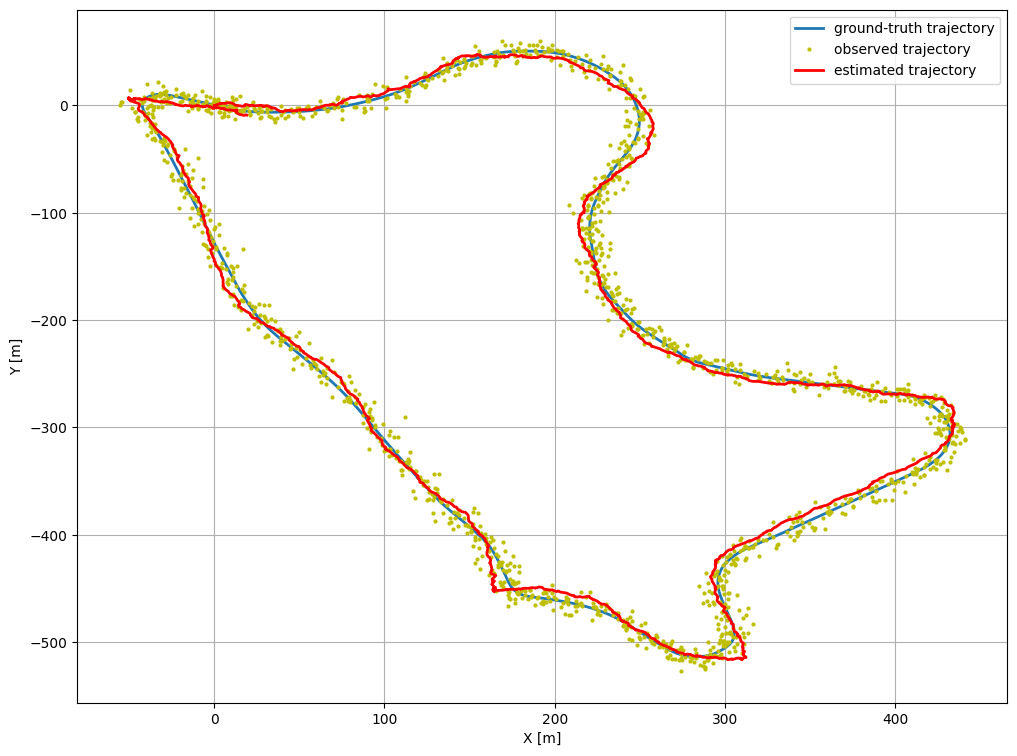

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = GPS_measurements_in_meter
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = GPS_mesurement_in_meter_with_noise
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory', color='y')

ax.plot(mu_x_setup1_2, mu_y_setup1_2, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

In [60]:
error_ekf = mean_squared_error(GPS_measurements_in_meter[:2, :len(mu_x_setup1_2)], np.array([mu_x_setup1_2, mu_y_setup1_2]))
print(f"MSE: {error_ekf}")

MSE: 23.206824532746175


## Setup2 (IMU input -> EKF with Visual Odometry and GPS measurement)

## Setup3 (INS input -> EKF with Visual Odometry and INS measurement)

In the setup3, state vector x is defined as:
$$\mathbf 
    x = 
    \begin{bmatrix}
        \mathtt{x} \\
        \mathtt{y} \\
        \mathtt{\theta}
    \end{bmatrix}
$$
where, x and y are coordinate in 2D space and $\theta$ represents the angle along z axis.

Since we obtain forward velocity and yaw rate from IMU sensor in Kitti dataset, we can assume that the vehicle follows the velocity motion model.

In velocity motion model, the vehicle is controlled by rotational and translational velocity, which results in control input vector u being as follows:
$$\mathbf 
    u = 
    \begin{bmatrix}
        \mathtt{v_{k}} \\
        \mathtt{w_{k}}
    \end{bmatrix}
$$
where, $v_{k}$ and $w_{k}$ represent linear and angular velocity respectively. Moreover, positive rotational velocity $w_{k}$ induces a counter clockwise rotation, left turn, whereas positive translational velocity $v_{k}$ corresponds to forward velocity.

We asssume that the vehicle has circular motion in short amount of time $\Delta t$ so that the state vector is obtained after $\Delta t$ of motion such that:

$$\mathbf 
    {\hat{x_{k}^{-}}} = 
    \begin{bmatrix}
        \mathtt{x_{c} + \frac{v}{w} * sin(\theta_{k-1} + w*\Delta t)} \\
        \mathtt{y_{c} + \frac{v}{w} * cos(\theta_{k-1} + w*\Delta t)} \\
        \mathtt{\theta_{k-1} + w*\Delta t} \\
    \end{bmatrix}
$$
where, $x_{c}$ and $y_{c}$ represent center of circular motion denoted as:

$$\begin{align}
    x_{c} &= x_{k-1} - \frac{v}{w}*sin(\theta_{k-1}) \\ 
    x_{y} &= y_{k-1} + \frac{v}{w}*cos(\theta_{k-1})
    \end{align}
$$

hence, by replacing $x_{c}$ and $y_{c}$ in the state vector equation, we obtain:
$$\mathbf 
    {\hat{x_{k}^{-}}} = 
    \begin{bmatrix}
        \mathtt{x_{k-1} - \frac{v}{w}*sin(\theta_{k-1}) + \frac{v}{w} * sin(\theta_{k-1} + w*\Delta t)} \\
        \mathtt{y_{k-1} + \frac{v}{w}*cos(\theta_{k-1}) + \frac{v}{w} * cos(\theta_{k-1} + w*\Delta t)} \\
        \mathtt{\theta_{k-1} + w*\Delta t} \\
    \end{bmatrix}
$$.

The prediction model of function f is denoted as:
$$\mathbf 
    f(x_{k-1}, u_{k}) = 
        \begin{bmatrix}
        \mathtt{f1} \\
        \mathtt{f2} \\
        \mathtt{f3} \\
    \end{bmatrix} = 
    \begin{bmatrix}
        \mathtt{x_{k-1} - \frac{v}{w}*sin(\theta_{k-1}) + \frac{v}{w} * sin(\theta_{k-1} + w*\Delta t)} \\
        \mathtt{y_{k-1} + \frac{v}{w}*cos(\theta_{k-1}) + \frac{v}{w} * cos(\theta_{k-1} + w*\Delta t)} \\
        \mathtt{\theta_{k-1} + w*\Delta t} \\
    \end{bmatrix}
$$.

To obtain Jacobian matrix from the function f, we need to find partial derivative of function f with respect to each variable in the state vector x. The Jacobian matrix is shown below.
$$\mathbf 
    F_{j} = 
    \begin{bmatrix}
        \mathtt{\frac{\partial f_{1}}{\partial x} \frac{\partial f_{1}}{\partial y}  \frac{\partial f_{1}}{\partial \theta} } \\
        \mathtt{\frac{\partial f_{2}}{\partial x} \frac{\partial f_{2}}{\partial y}  \frac{\partial f_{2}}{\partial \theta} } \\
        \mathtt{\frac{\partial f_{3}}{\partial x} \frac{\partial f_{3}}{\partial y}  \frac{\partial f_{3}}{\partial \theta} } \\
    \end{bmatrix} = 
    \begin{bmatrix}
        1 & 0 & - \frac{v}{w}*cos(\theta_{k-1}) + \frac{v}{w}*cos(\theta_{k-1} + w*\Delta t)  \\
        0 & 1 & - \frac{v}{w}*sin(\theta_{k-1}) + \frac{v}{w}*sin(\theta_{k-1} + w*\Delta t)  \\
        0 & 0 & 1 \\
    \end{bmatrix}
$$.

In terms of the measurement model, we have $x$ and $y$ coordinate from GPS sensor and the state-to-measurement matrix is obtained such that
$$\begin{align}
    z_{k} &= [x_{k} y_{k}]^{T} + R \\ 
    &= H_{k} * x_{k} + R
    \end{align}
$$
where,
$$\mathbf 
    H_{k} = 
    \begin{bmatrix}
        1 & 0 & 0 \\
        0 & 1 & 0 \\
    \end{bmatrix}
$$.
Since the measurement model is linear function, we don't need to compute Jacobian matrix.

In [72]:
class ExtendedKalmanFilter_setup3_1:
    """Extended Kalman Filter
    for vehicle whose motion is modeled as eq. (5.9) in [1]
    and with observation of its 2d location (x, y)

    Jacobian matrix F and G are obtained from the sympy's jacobian method calculated in EKF-setup3-sympy.ipynb
    """
    x = None
    Q = None
    P = None
    def __init__(self, dim_x=3, dim_z=2):
        """ 
        Args:
            x (numpy.array): state to estimate: [x_, y_, theta]^T
            P (numpy.array): estimation error covariance
        """
        self.n = dim_x
        self.m = dim_z

    def predict(self, u, dt, Q):
        """estimate x and P based on previous stete of x and control input u
        Args:
            u  (numpy.array): control input u
            dt (numpy.array): difference of current time and previous time
            Q  (numpy.array): process noise 
        """
        # propagate state x
        x, y, theta = self.x
        v, omega = u
        r = v / omega  # turning radius

        dtheta = omega * dt
        dx = - r * np.sin(theta) + r * np.sin(theta + dtheta)
        dy = + r * np.cos(theta) - r * np.cos(theta + dtheta)

        self.x += np.array([dx, dy, dtheta])

        # propagate covariance P
        # Jacobian of state transition function
        F = np.array([
            [1., 0., - r * np.cos(theta) + r * np.cos(theta + dtheta)],
            [0., 1., - r * np.sin(theta) + r * np.sin(theta + dtheta)],
            [0., 0., 1.]
        ]) 

        # Jacobian of state transition function
        G = np.array([
            [-np.sin(theta)/omega + np.sin(theta + dtheta)/omega, dt*v*np.cos(theta+dtheta)/omega + v*np.sin(theta)/omega**2 - v*np.sin(theta+dtheta)/omega**2],
            [np.cos(theta)/omega - np.cos(theta+dtheta)/omega, dt*v*np.sin(theta+dtheta)/omega - v*np.cos(theta)/omega**2 + v*np.cos(theta+dtheta)/omega**2],
            [0., dt]
        ]) 
        
        self.P = F @ self.P @ F.T + G @ Q @ G.T
        
    def update(self, z, R):
        """update x and P based on observation of (x_, y_)
        Args:
            z (numpy.array): measurement for [x_, y_]^T
            R (numpy.array): measurement noise covariance
        """
        # compute Kalman gain
        # Jacobian of observation function
        H = np.array([
            [1., 0., 0.],
            [0., 1., 0.]
        ])

        K = self.P @ H.T @ np.linalg.inv(H @ self.P @ H.T + R)

        # update state x
        x, y, theta = self.x
        z_ = np.dot(H, self.x)  # expected observation from the estimated state
        self.x = self.x + K @ (z - z_)

        # update covariance P
        self.P = self.P - K @ H @ self.P


In [75]:
# state vector x
initial_x = np.array([
    GPS_measurements_in_meter[0, 0], #Px
    GPS_measurements_in_meter[1, 0], #Py
    IMU_outputs[0, 5]
])

# covariance for state vector x
initial_P = np.eye(initial_x.shape[0]) * 0.1

# process noise
q_noise3 = [velocity_noise_std, IMU_angular_velocity_noise_std]
i = np.eye(2)
Q_ = np.array([[val * num for num in i[ind]] for ind, val in enumerate(q_noise3)])
# Q_ = np.array([
#     [GPS_measurement_noise_std ** 2., 0., 0.],
#     [0., GPS_measurement_noise_std ** 2., 0.],
#     [0., 0., IMU_angular_velocity_noise_std ** 2.],
# ])

# measurement noise
R_ = np.array([
    [GPS_measurement_noise_std ** 2., 0.],
    [0., GPS_measurement_noise_std ** 2.],
])

# transition matrix H
H_ = np.array([
    [1., 0., 0.],
    [0., 1., 0.]
])
ekf3_1 = ExtendedKalmanFilter_setup3_1(dim_x=3, dim_z=2)
ekf3_1.x=initial_x.copy()
ekf3_1.P=initial_P.copy()
ekf3_1.Q=Q_.copy()
ekf3_1.R=R_.copy()
ekf3_1.H=H_.copy()


In [76]:
mu_x_setup3_1 = [ekf3_1.x[0],]
mu_y_setup3_1 = [ekf3_1.x[1],]
mu_theta_setup3_1 = [ekf3_1.x[2],]
t_last = 0.
for t_idx in range(1, N):
    t = ts[t_idx]
    dt = t - t_last
    # control vector
    u = np.array([
        INS_velocities_with_noise[t_idx, 0],
        IMU_angular_velocity_with_noise[t_idx, 2]
    ])
    ekf3_1.predict(u=u, dt=dt, Q=Q_)
    x_hat = ekf3_1.x.copy()
    mu_x_setup3_1.append(x_hat[0])
    mu_y_setup3_1.append(x_hat[1])
    mu_theta_setup3_1.append(x_hat[2])    
    z_ = GPS_mesurement_in_meter_with_noise[:2, t_idx]
    ekf3_1.update(z=z_, R=R_)
    t_last = t

## Visualize estimated results

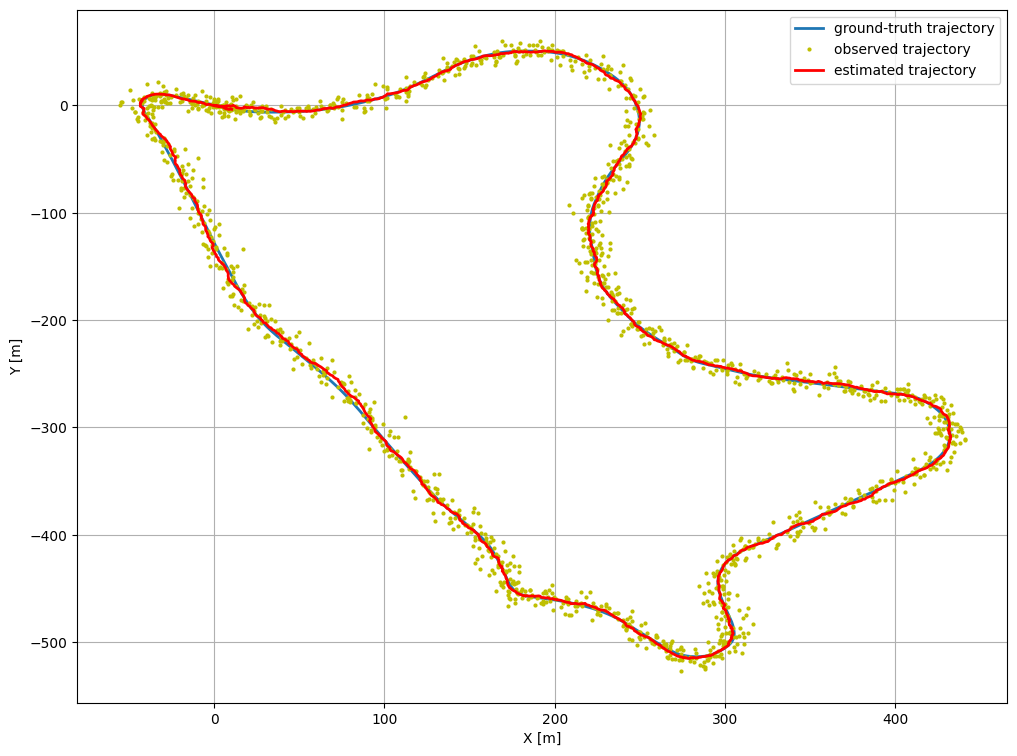

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = GPS_measurements_in_meter
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = GPS_mesurement_in_meter_with_noise
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory', color='y')

ax.plot(mu_x_setup3_1, mu_y_setup3_1, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

In [78]:
error_ekf = mean_squared_error(GPS_measurements_in_meter[:2, :], np.array([mu_x_setup3_1, mu_y_setup3_1]))
print(f"MSE: {error_ekf}")

MSE: 0.8127932054552433


In [66]:
class ExtendedKalmanFilter3_2:
    """Extended Kalman Filter
    for vehicle whose motion is modeled as eq. (5.9) in [1]
    and with observation of its 2d location (x, y)
    """
    x = None
    P = None
    R = None
    H = None
    px = symbols('p_{x}')
    py = symbols('p_{y}')
    theta = symbols('theta')
    v = symbols('v')
    w = symbols('w')
    dt = symbols('dt')
        
    errors = []
    
    def __init__(self, x, P, H):
        """ 
        Args:
            x (numpy.array): state to estimate: [x_, y_, theta]^T
            P (numpy.array): estimation error covariance
        """
        
        self.fxu = Matrix([
            [self.px - self.v*sympy.sin(self.theta)/self.w + self.v*sympy.sin(self.theta + self.w*self.dt)/self.w],
            [self.py + self.v*sympy.cos(self.theta)/self.w - self.v*sympy.cos(self.theta + self.w*self.dt)/self.w],
            [self.theta + self.w*self.dt]
        ])
        state_x = Matrix([self.px, self.py, self.theta])
        control_input = Matrix([self.v, self.w])

        self.F = self.fxu.jacobian(state_x)
        self.G = self.fxu.jacobian(control_input)
        self.P = P
        self.H = H
        self.x = x
        
    def predict(self, u, dt, Q):
        """estimate x and P based on previous stete of x and control input u
        Args:
            u  (numpy.array): control input u
            dt (numpy.array): difference of current time and previous time
            Q  (numpy.array): process noise 
        """
        # propagate state x
        px_, py_ = self.x[:2, 0]
        theta_ = self.x[-1, 0]
        v_, w_ = u
        fxu_values = {
            self.dt: dt,
            self.px: px_,
            self.py: py_,
            self.theta: theta_,
            self.v: v_,
            self.w: w_
        }
        # predict state vector x
        self.x = np.array(self.fxu.evalf(subs=fxu_values)).astype(float)

        # predict state covariance matrix P
        P_hat = self.F @ self.P @ self.F.T + self.G @ Matrix(Q) @ self.G.T
        self.P = np.array(P_hat.evalf(subs=fxu_values)).astype(float)
        
    def update(self, z, R):
        """update x and P based on observation of (x_, y_)
        Args:
            z (numpy.array): measurement for [x_, y_]^T
            R (numpy.array): measurement noise covariance
        """
        # compute Kalman gain
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + R)
        # update state x
        z_ = np.dot(self.H, self.x)  # expected observation from the estimated state
        self.x = self.x + K @ (z - z_)
        
        self.errors.append(np.sqrt(np.sum((z-z_)**2)))
        
        # update covariance P
        self.P = self.P - K @ self.H @ self.P

    def plot_error(self):
        plt.plot([i for i in range(len(self.errors))], self.errors, label='Error', color='r')

In [67]:
# state vector x
initial_x_setup3 = np.array([
    [GPS_measurements_in_meter[0, 0]], #px
    [GPS_measurements_in_meter[1, 0]], #py
    [IMU_outputs[0, 5]] #theta
])

# covariance for state vector x
initial_P = np.eye(initial_x_setup3.shape[0]) * 0.1

# process noise
q_noise3 = [velocity_noise_std, IMU_angular_velocity_noise_std]
i = np.eye(2)
Q_ = Matrix([[val * num for num in i[ind]] for ind, val in enumerate(q_noise3)])
# Q_ = np.array([
#     [0.1, 0., 0.],
#     [0., 0.1, 0.],
#     [0., 0., 0.1]
# ])

# measurement noise
R_ = np.array([
    [GPS_measurement_noise_std ** 2., 0.],
    [0., GPS_measurement_noise_std ** 2.],
])

# transition matrix H
H_ = np.array([
    [1., 0., 0.],
    [0., 1., 0.]
])
ekf3_2 = ExtendedKalmanFilter3_2(x=initial_x_setup3, P=initial_P, H=H_)

In [68]:
mu_x_setup3_2 = [ekf3_2.x[0, 0],]
mu_y_setup3_2 = [ekf3_2.x[1, 0],]
t_last = 0.

for t_idx in tqdm(range(1, N)):
    t = ts[t_idx]
    dt_ =  t - t_last
    vf_ = INS_velocities_with_noise[t_idx, 0] # forward velocity
    wz_ = IMU_angular_velocity_with_noise[t_idx, 2]
    u_ = np.array([
        vf_,
        wz_,
    ])
    ekf3_2.predict(u=u_, dt=dt_, Q=Q_)
    x_hat = ekf3_2.x.copy()
    mu_x_setup3_2.append(x_hat[0, 0])
    mu_y_setup3_2.append(x_hat[1, 0])
    z_ = GPS_mesurement_in_meter_with_noise[:2, t_idx]
    ekf3_2.update(z=z_.reshape(-1, 1), R=R_)
    t_last = t

100%|███████████████████████████████████████| 1593/1593 [00:55<00:00, 28.46it/s]


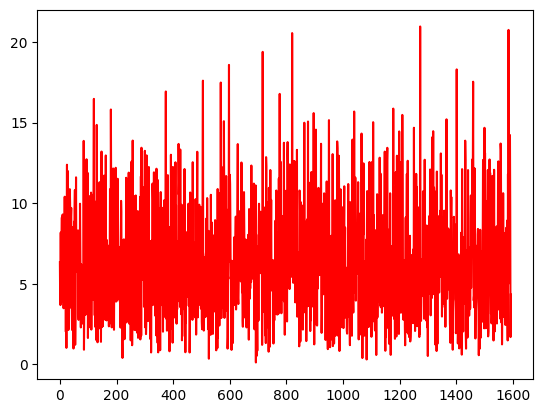

In [69]:
ekf3_2.plot_error()

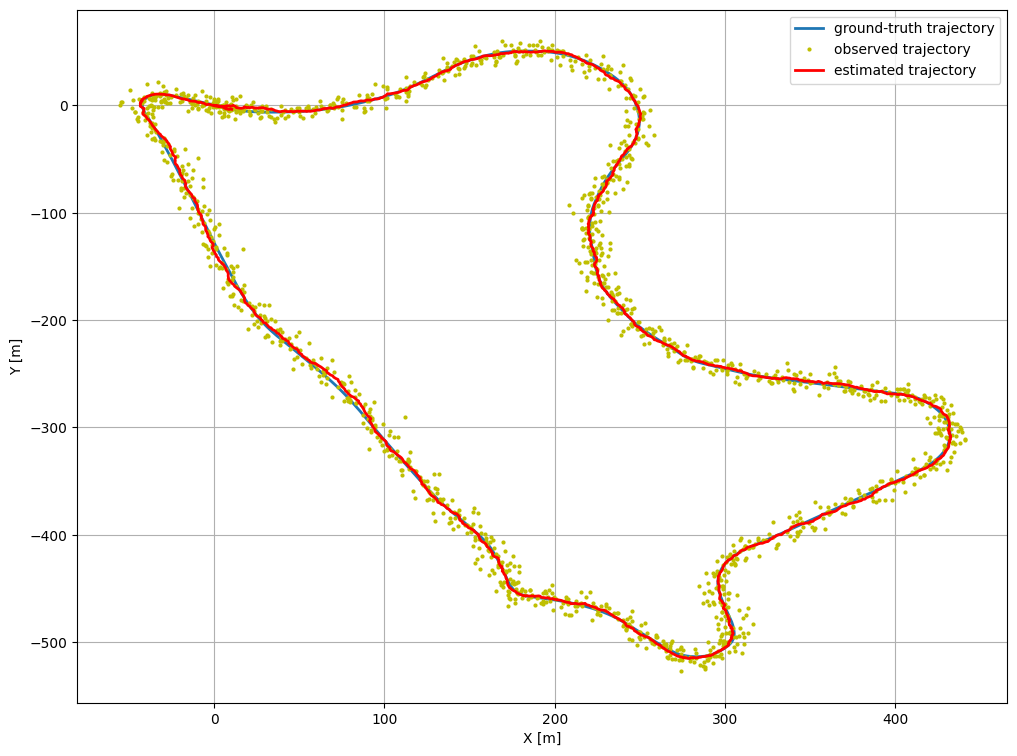

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = GPS_measurements_in_meter
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = GPS_mesurement_in_meter_with_noise
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory', color='y')

ax.plot(mu_x_setup3_2, mu_y_setup3_2, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

In [71]:
error_ekf = mean_squared_error(GPS_measurements_in_meter[:2, :], np.array([mu_x_setup3_2, mu_y_setup3_2]))
print(f"MSE: {error_ekf}")

MSE: 0.8127932079887674
